In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering as SC


In [33]:
class SpectralClustering:
    def __init__(self, n_clusters=4, graph_type='nearest_neighbors', k_neighbors=5, similarity='gaussian_kernel', sigma=0.1, threshold=0.05):
        self.n_clusters = n_clusters
        self.graph_type = graph_type
        self.similarity = similarity
        self.sigma = sigma
        self.k_neighbors = k_neighbors
        self.threshold = threshold
        
        self.W: np.ndarray = None
        self.D: np.ndarray = None
        self.L: np.ndarray = None
        self.L_norm: np.ndarray = None
        self.L_sym: np.ndarray = None
        self.new_X: np.ndarray = None
    
    def gaussian_kernel(self, x, y):
        W_x_y = np.exp(-np.square(x - y).sum(axis=1)/(self.sigma**2))
        return W_x_y

    def get_laplacian(self, D, W, l_type='standard'):
        L = D - W
        D_inv = LA.inv(D)
        D_sqrt_inv =  LA.inv(LA.sqrtm(D))
        if l_type == 'standard':
            return L
        elif l_type == 'norm':
            return D_inv.dot(L)
        elif l_type == 'sym':
            return np.identity(D.shape[0]) - D_sqrt_inv.dot(W).dot(D_sqrt_inv)

    def fit(self, X):
        if self.graph_type == 'nearest_neighbors':
            dist = pairwise_distances(X, X)
            s = dist.sum()
            np.fill_diagonal(dist, s)

            indices = []
            for _ in range(self.k_neighbors):
                indices.append(np.argmin(dist, axis=1))
                dist[range(dist.shape[0]), np.argmin(dist, axis=1)] = s
            indices = np.array(indices).T
            self.W = np.zeros((X.shape[0], X.shape[0]))
            for i in range(X.shape[0]):
                self.W[i, indices[i]] = self.gaussian_kernel(X[i], X[indices[i]])

        elif self.graph_type == 'full':
            gaussian_kernel = rbf_kernel(X, gamma=1/(self.sigma**2))
            np.fill_diagonal(gaussian_kernel, 0)
            self.W = gaussian_kernel

        elif self.graph_type == 'eps-neighborhood':
            gaussian_kernel = rbf_kernel(X, gamma=1/(self.sigma**2))
            np.fill_diagonal(gaussian_kernel, 0)
            self.W = gaussian_kernel * (gaussian_kernel > self.threshold)

        self.W = np.maximum(self.W, self.W.T)
        self.D = np.zeros((X.shape[0], X.shape[0]))
        np.fill_diagonal(self.D, self.W.sum(axis=1))
        
        L = self.get_laplacian(self.D, self.W, l_type='sym')
        # L = np.maximum(L, L.T)
        
        self.new_X = LA.eigh(L)[1][:, 1:self.n_clusters]

    def fit_predict(self, X):
        self.fit(X)
        clf = KMeans(n_clusters=self.n_clusters)
        y = clf.fit_predict(self.new_X)
        return y



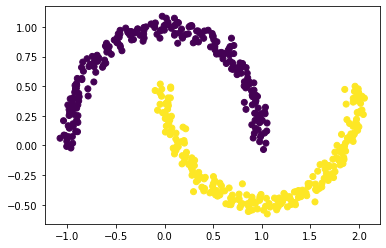

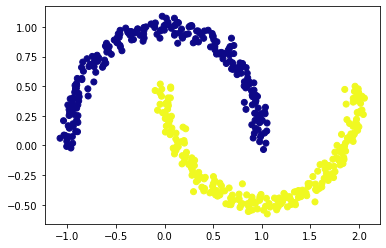

In [34]:
n_samples = 500
n_features = 2
sigma=1
n_clusters = 2
k_neighbors = 7
graph_type = 'eps-neighborhood'
threshold = 0.9

X, y_true = make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X, y_true = make_moons(n_samples=n_samples, noise=0.05)
# X, y_true = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters)

plt.scatter(X[:,0], X[:,1], c=y_true)
plt.show()
    
clf = SpectralClustering(
    sigma=1,
    k_neighbors=k_neighbors,
    n_clusters=n_clusters,
    graph_type=graph_type,
    threshold=threshold)

y_pred = clf.fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=y_pred, cmap='plasma')
plt.show()
